In [33]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/musescore'
us['musicxmlPath'] = '/usr/bin/musescore'

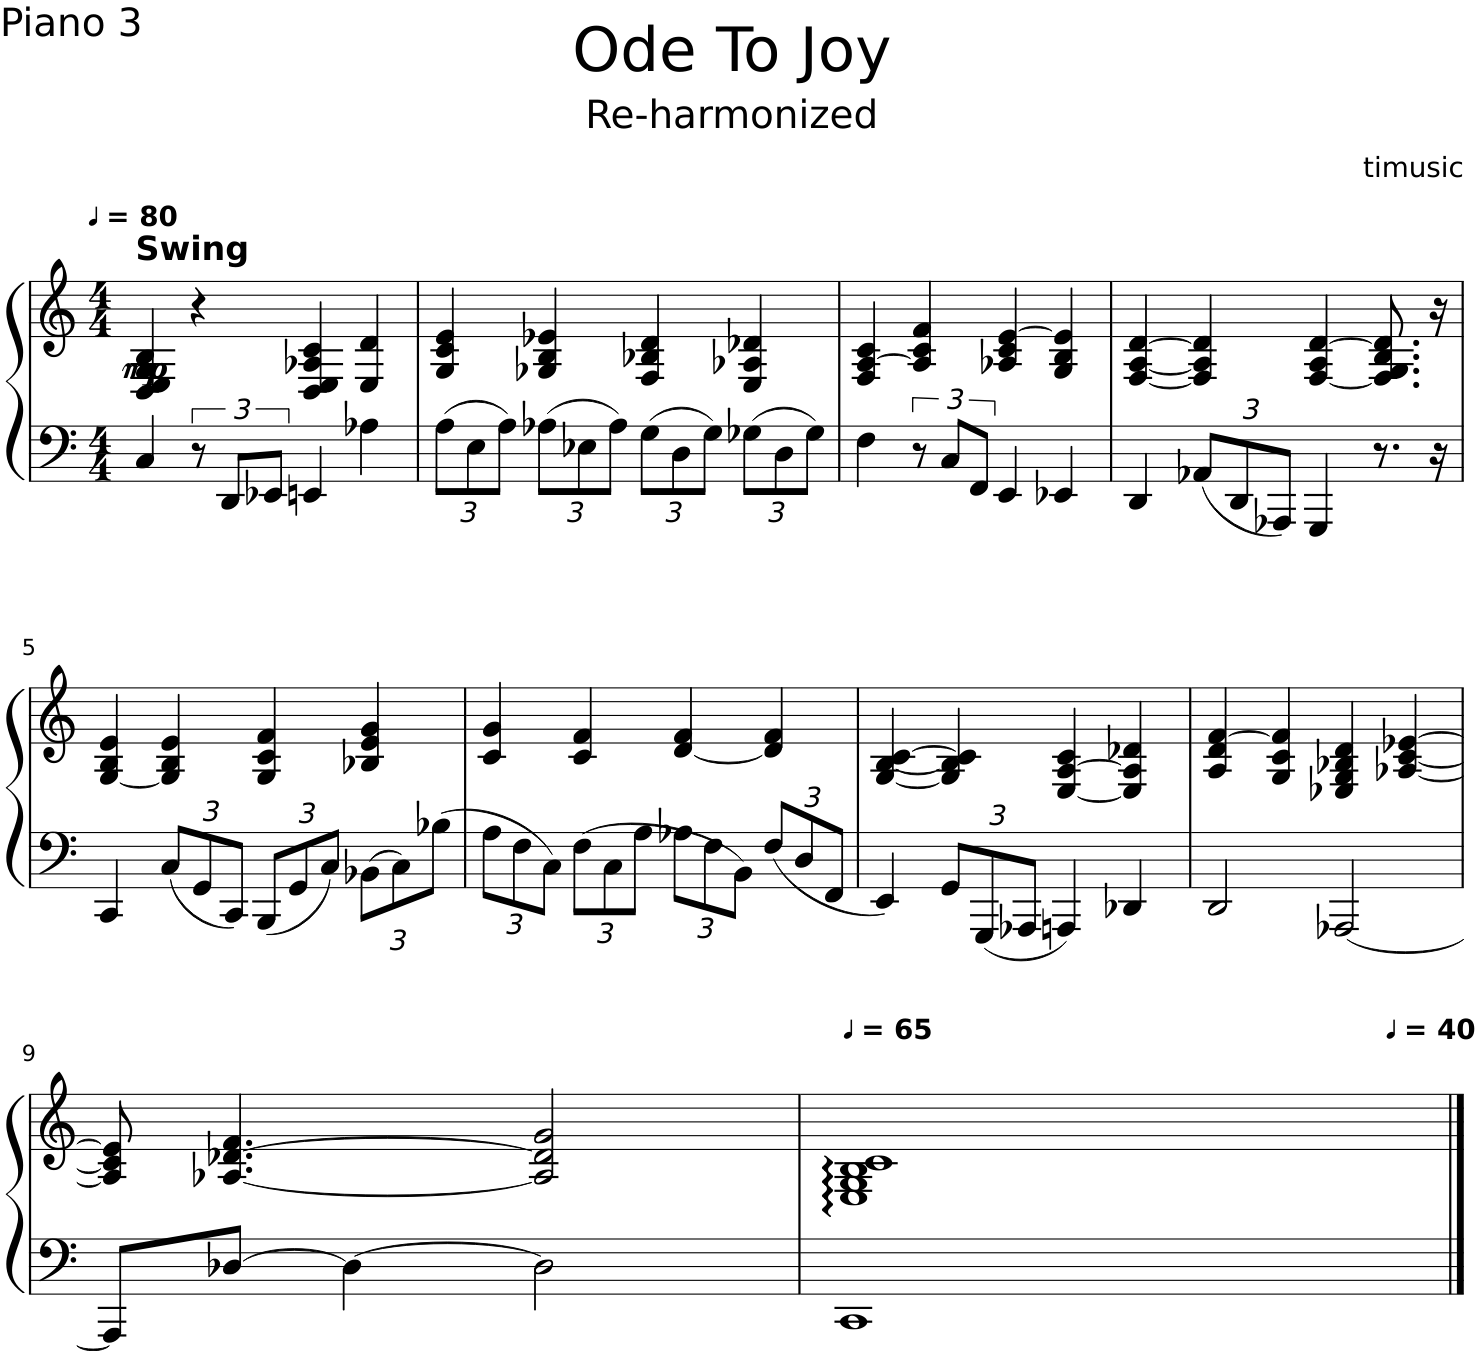

In [92]:
s = converter.parse("ode2joy.musicxml")
#s = converter.parse("Untitled_score-Piano.musicxml").flatten().chordify()
s.show()

In [100]:
for n in s.recurse():
    if type(n) == chord.Chord:
        for my_note in n:
            print(my_note.pitch)

D3
E3
G3
B3
D3
E3
A-3
C4
E3
D4
G3
C4
E4
G-3
B3
E-4
F3
B-3
D4
E3
A-3
D-4
F3
A3
C4
A3
C4
F4
A-3
C4
E4
G3
B3
E4
F3
A3
D4
F3
A3
D4
F3
A3
D4
F3
G3
B3
D4
G3
B3
E4
G3
B3
E4
G3
C4
F4
B-3
E4
G4
C4
G4
C4
F4
D4
F4
D4
F4
G3
B3
C4
G3
B3
C4
E3
A3
C4
E3
A3
D-4
A3
D4
F4
G3
C4
F4
E-3
G3
B-3
D4
A-3
C4
E-4
A-3
C4
E-4
A-3
D-4
F4
A-3
D-4
G4
E3
G3
B3
C4
